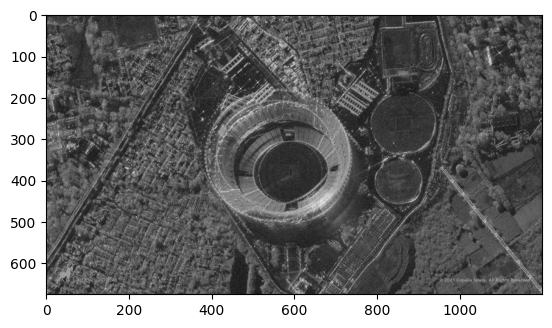

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity, mean_squared_error

image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(image_gray, cmap="gray")

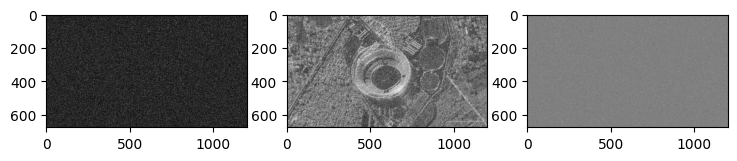

In [8]:
mean = 0
stddev = 100
noise_gauss = np.zeros(image_gray.shape, np.uint8)
cv2.randn(noise_gauss, mean, stddev)

noise =  np.random.randint(0, 101, size = (image_gray.shape[0], image_gray.shape[1]), dtype=int)
zeros_pixel = np.where(noise == 0)
ones_pixel = np.where(noise == 100)

bg_image = np.ones(image_gray.shape, np.uint8) * 128

bg_image[zeros_pixel] = 0
bg_image[ones_pixel] = 255


image_noise_gauss = cv2.add(image_gray,noise_gauss)

plt.figure(figsize=(15, 5))
plt.subplot(1, 5, 1)
plt.imshow(noise_gauss, cmap="gray")

plt.subplot(1, 5, 2)
plt.imshow(image_noise_gauss, cmap="gray")

plt.subplot(1, 5, 3)
plt.imshow(bg_image, cmap="gray")

In [12]:

print("медианный фильтр")
results = []
for ksize in [3, 5, 7]:
    filtered = cv2.medianBlur(image_noise_gauss, ksize)
    mse = mean_squared_error(image_gray, filtered)
    ssim = structural_similarity(image_gray, filtered, data_range=filtered.max()-filtered.min())
    results.append({
            'filter': 'Median',
            'params': f'ksize={ksize}',
            'mse': mse,
            'ssim': ssim,
            'image': filtered
        })
    print(f"  ksize={ksize}: MSE={mse:.4f}, SSIM={ssim:.4f}")
    
    print("фильтр гаусса")
    for ksize in [3, 5, 7]:
        for sigma in [0.5, 1.0, 1.5]:
            filtered = cv2.GaussianBlur(image_noise_gauss, (ksize, ksize), sigma)
            mse = mean_squared_error(image_gray, filtered)
            ssim = structural_similarity(image_gray, filtered, data_range=filtered.max()-filtered.min())
            results.append({
                'filter': 'Gaussian',
                'params': f'ksize={ksize}, sigma={sigma}',
                'mse': mse,
                'ssim': ssim,
                'image': filtered
            })
            print(f"  ksize={ksize}, sigma={sigma}: MSE={mse:.4f}, SSIM={ssim:.4f}")
    
    print("билатериальный фильтр")
    for d in [5, 9, 15]:
        for sigma_color in [25, 50, 75]:
            for sigma_space in [25, 50, 75]:
                filtered = cv2.bilateralFilter(image_noise_gauss, d, sigma_color, sigma_space)
                mse = mean_squared_error(image_gray, filtered)
                ssim = structural_similarity(image_gray, filtered, data_range=filtered.max()-filtered.min())
                results.append({
                    'filter': 'Bilateral',
                    'params': f'd={d}, sigma_color={sigma_color}, sigma_space={sigma_space}',
                    'mse': mse,
                    'ssim': ssim,
                    'image': filtered
                })
                print(f"  d={d}, sigma_color={sigma_color}, sigma_space={sigma_space}: MSE={mse:.4f}, SSIM={ssim:.4f}")
    
    print("фильтр нелокальных средних")
    for h in [3, 5, 10]:
        for templateWindowSize in [7, 11]:
            for searchWindowSize in [21, 35]:
                filtered = cv2.fastNlMeansDenoising(image_noise_gauss, None, h, templateWindowSize, searchWindowSize)
                mse = mean_squared_error(image_gray, filtered)
                ssim = structural_similarity(image_gray, filtered, data_range=filtered.max()-filtered.min())
                results.append({
                    'filter': 'Non-local Means',
                    'params': f'h={h}, templateWindowSize={templateWindowSize}, searchWindowSize={searchWindowSize}',
                    'mse': mse,
                    'ssim': ssim,
                    'image': filtered
                })
                print(f"  h={h}, templateWindowSize={templateWindowSize}, searchWindowSize={searchWindowSize}: MSE={mse:.4f}, SSIM={ssim:.4f}")
    


медианный фильтр
  ksize=3: MSE=1038.0453, SSIM=0.4203
фильтр гаусса
  ksize=3, sigma=0.5: MSE=2618.0080, SSIM=0.2937
  ksize=3, sigma=1.0: MSE=1869.9636, SSIM=0.4387
  ksize=3, sigma=1.5: MSE=1850.5793, SSIM=0.4375
  ksize=5, sigma=0.5: MSE=2618.0080, SSIM=0.2937
  ksize=5, sigma=1.0: MSE=1778.3571, SSIM=0.4663
  ksize=5, sigma=1.5: MSE=1734.5151, SSIM=0.4638
  ksize=7, sigma=0.5: MSE=2618.0080, SSIM=0.2937
  ksize=7, sigma=1.0: MSE=1771.6514, SSIM=0.4678
  ksize=7, sigma=1.5: MSE=1720.3204, SSIM=0.4619
билатериальный фильтр
  d=5, sigma_color=25, sigma_space=25: MSE=3872.5774, SSIM=0.1826
  d=5, sigma_color=25, sigma_space=50: MSE=3872.4370, SSIM=0.1826
  d=5, sigma_color=25, sigma_space=75: MSE=3872.4024, SSIM=0.1826
  d=5, sigma_color=50, sigma_space=25: MSE=2868.6797, SSIM=0.2306
  d=5, sigma_color=50, sigma_space=50: MSE=2868.2650, SSIM=0.2306
  d=5, sigma_color=50, sigma_space=75: MSE=2868.1958, SSIM=0.2306
  d=5, sigma_color=75, sigma_space=25: MSE=2027.4501, SSIM=0.3171
  d=5,

In [13]:
best_ssim = sorted(results, key=lambda x: x['ssim'], reverse=True)[:5]
print("\nтоп 5 по SSIM:")
for i, result in enumerate(best_ssim):
    print(f"{i+1}. {result['filter']} [{result['params']}] - SSIM: {result['ssim']:.4f}, MSE: {result['mse']:.4f}")
    
    # Лучшие по MSE
best_mse = sorted(results, key=lambda x: x['mse'])[:5]
print("\nтоп 5 по MSE:")
for i, result in enumerate(best_mse):
    print(f"{i+1}. {result['filter']} [{result['params']}] - MSE: {result['mse']:.4f}, SSIM: {result['ssim']:.4f}")


топ 5 по SSIM:
1. Gaussian [ksize=7, sigma=1.0] - SSIM: 0.4678, MSE: 1771.6514
2. Gaussian [ksize=7, sigma=1.0] - SSIM: 0.4678, MSE: 1771.6514
3. Gaussian [ksize=7, sigma=1.0] - SSIM: 0.4678, MSE: 1771.6514
4. Gaussian [ksize=5, sigma=1.0] - SSIM: 0.4663, MSE: 1778.3571
5. Gaussian [ksize=5, sigma=1.0] - SSIM: 0.4663, MSE: 1778.3571

топ 5 по MSE:
1. Median [ksize=7] - MSE: 682.5692, SSIM: 0.4083
2. Median [ksize=5] - MSE: 706.0309, SSIM: 0.4522
3. Median [ksize=3] - MSE: 1038.0453, SSIM: 0.4203
4. Gaussian [ksize=7, sigma=1.5] - MSE: 1720.3204, SSIM: 0.4619
5. Gaussian [ksize=7, sigma=1.5] - MSE: 1720.3204, SSIM: 0.4619
